# Машинное обучение, DS-поток
## Задание 1.2


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds20_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

**Задание стоит 15 баллов.**

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)
plt.rcParams['axes.facecolor'] = 'lightgrey'

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $$Q(X_m, j, t) = \frac{|X_l|}{|X_m|} H(X_l) + \frac{|X_r|}{|X_m|} H(X_r)$$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** общая идея критериев информативности --- охарактеризовать разнородность данных в выборке. Они стремятся оптимизировать разброс значений элементов выборки.


Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy` — массив размерности `(n,)` из значений отклика.

In [9]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    y_copy = np.asarray(y)
    return np.mean((y_copy - y_copy.mean())**2)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    y_copy = np.asarray(y)
    return np.mean(np.abs(y_copy - y_copy.mean()))


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''

    y_copy = np.asarray(y)
    unique, counts = np.unique(y_copy, return_counts=True)
    return counts / y_copy.shape[0]


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    
    probs = get_probs_by_y(y)
    return -np.sum(probs * np.log(probs))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [10]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [11]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализовать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


* `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,
* `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,
* `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

* `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

* `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

* `predict` — получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.
* `predict_proba_instance` — предсказание распределения вероятностей по классам для одного элемента выборки, 
* `predict_proba` — предсказание распределения вероятностей по классам для всех элементов выборки,
* `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** в качестве пороговых перебираться будут только те значения, что встречаются в текущей вершине. Другие перебирать нет смысла, так как при промежуточных значениях попадающие влево и вправо элементы такие же, что и при пороговом.

**Структура решающего дерева**


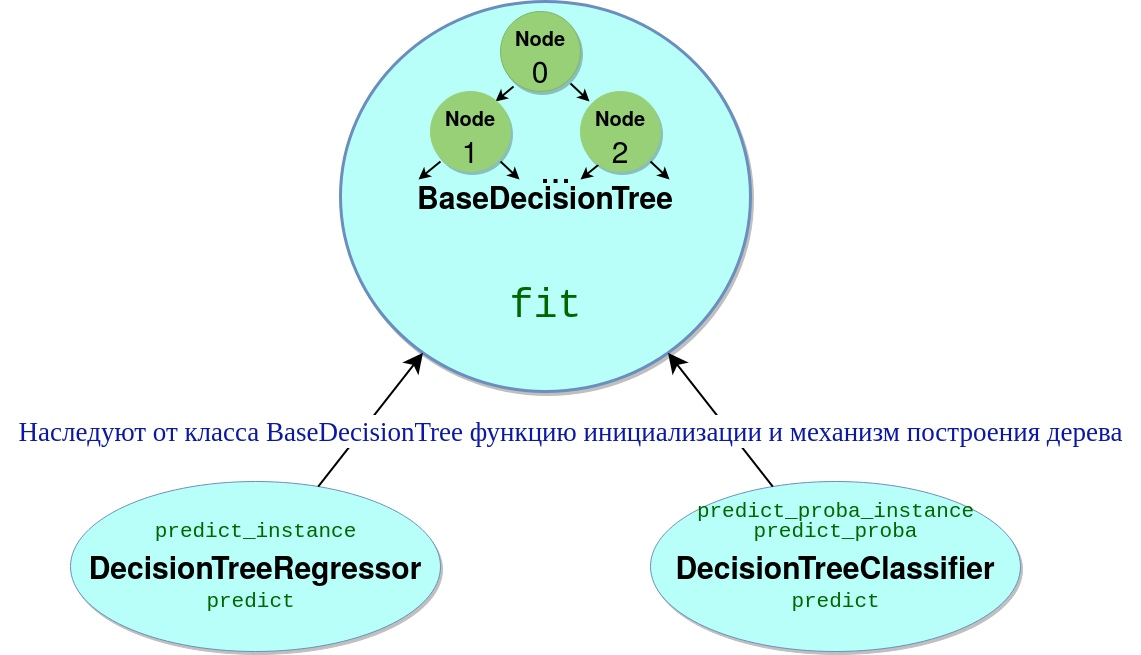

In [16]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[arr != None]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold

        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None

        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0

        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]

        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1

        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета
        # (они будут нашими порогами).
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        if depth == self.max_depth or len(y) < self.min_samples_split:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                left_inds = X[:, feature_id] < threshold
                # TODO: Стоит ли пропихивать в оба поддерева NaN?
                cur_criterion_value = self.criterion(
                    get_not_nans(y[left_inds]))
                +\
                self.criterion(get_not_nans(y[not left_inds]))
                
                # *Замечание.* Я специально сделал знак >=, чтобы не было
                # ситуации, когда в левую вершину попадает пустое подмножество
                if best_criterion_value >= cur_criterion_value:
                    best_criterion = cur_criterion_value
                    best_feature = feature_id
                    best_threshold = threshold
            
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        left_inds = X[:, best_feature] < best_threshold
        X_l, X_r = X[left_inds], X[not left_inds]
        y_l, y_r = y[left_inds], y[not left_inds]
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes) - 2, len(self.nodes) - 1

        # рекурсивно строим дерево для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth + 1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth + 1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, "set_class_count", None)
        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [18]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        # если вершина — лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son == None:
            return self.nodes[v].y_values
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return (left_predict + right_predict) / 2
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [ ]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son == None:
            # считаем долю каждого класса и возвращаем вектор вероятностей 
            return get_probs_by_y(self.nodes[v].y_values)
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return <...>
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
        
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [ ]:
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`.

In [ ]:
classification_criteria = <...>
criterion_names = <...>

С начала надо разбить выборку на train и test.

In [ ]:
X_train, X_test, y_train, y_test = <...>

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [ ]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    accuracy = <...>
    print('accuracy:', accuracy)
    assert(accuracy >= 0.85, "Something is wrong with your classifier")

**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14. Значение `min_samples_split` фиксируйте.

In [ ]:
# код построения графиков
<...>

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**

<...>

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите r2_score. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [ ]:
from sklearn.datasets import load_boston

boston_X, boston_y = load_boston(return_X_y=True)

In [ ]:
regression_criteria = <...>
criterion_names = <...>

In [ ]:
<...>

Разобьём выборку на обучение и тест.

In [ ]:
X_train, X_test, y_train, y_test = <...>

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [ ]:
<...>

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

<...>

### Обработка пропусков с использованием решающих деревьев.

А теперь рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [ ]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [ ]:
adult_df = pd.read_csv('adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [ ]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [ ]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [ ]:
np.sum(adult_df.isnull(), axis=0)

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [ ]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [ ]:
<...>

Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [ ]:
<...>

**Вывод.**

<...>